In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    recall_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
movies = pd.read_csv("movie_dataset.csv")
liked = pd.read_csv("liked_films.csv")

movies['title_clean'] = movies['title'].str.lower().str.strip()
liked['name_clean'] = liked['Name'].str.lower().str.strip()

movies['is_favorite'] = movies['title_clean'].isin(liked['name_clean']).astype(int)

movies['is_favorite'].value_counts()


print("Favorite movies:", movies['is_favorite'].sum())
print("Total movies:", len(movies))


Favorite movies: 69
Total movies: 512


In [3]:
import ast

def parse_genres(x):
    if pd.isna(x) or x == '':
        return []
    try:
        return ast.literal_eval(x)
    except:
        return []

movies['genre_list'] = movies['genres'].apply(parse_genres)


In [74]:

movies_ml = movies[
    (movies['imdb_rating'] >= 6.5) &
    (movies['rt_rating'] >= 70)
].copy()

movies_ml['is_favorite'].value_counts()


is_favorite
0    378
1     67
Name: count, dtype: int64

In [75]:
top_genres = (
    movies_ml['genre_list']
    .explode()
    .value_counts()
    .head(8)
    .index
)

for g in top_genres:
    movies_ml[f'genre_{g}'] = movies_ml['genre_list'].apply(lambda x: int(g in x))

genre_cols = [f'genre_{g}' for g in top_genres]


In [76]:
num_features = movies_ml[
    ['imdb_rating', 'rt_rating', 'runtime',
     'oscar_wins', 'oscar_nominations']
].fillna(0)


In [77]:
X = pd.concat(
    [
        num_features.reset_index(drop=True),
        movies_ml[genre_cols].reset_index(drop=True)
    ],
    axis=1
)

y = movies_ml['is_favorite']

print("Feature count:", X.shape[1])


Feature count: 13


In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)
print("Training set size:", X_train.shape[0])

Training set size: 333


In [80]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X.columns,
    index=X_test.index
)

log_model = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    solver='liblinear'
)

log_model.fit(X_train_scaled, y_train)

y_proba = log_model.predict_proba(X_test_scaled)[:, 1]

# Lower threshold → better recall
threshold = 0.30
y_pred = (y_proba >= threshold).astype(int)


print("Recall (favorites):", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))



Recall (favorites): 0.9411764705882353
F1-score: 0.27586206896551724

              precision    recall  f1-score   support

           0       0.92      0.13      0.22        95
           1       0.16      0.94      0.28        17

    accuracy                           0.25       112
   macro avg       0.54      0.53      0.25       112
weighted avg       0.81      0.25      0.23       112



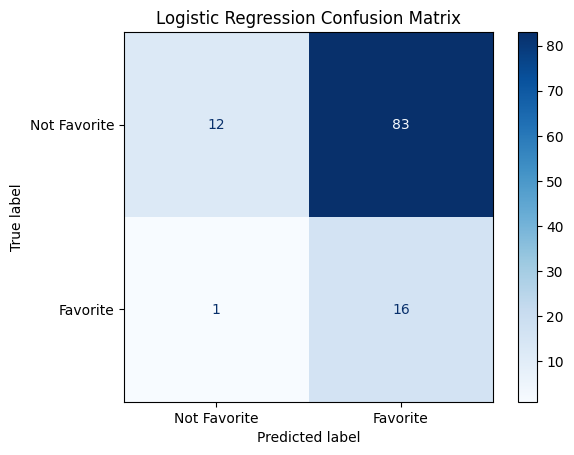

In [81]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Favorite", "Favorite"]
)

disp.plot(cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()



In [45]:
coef_df = pd.Series(
    log_model.coef_[0],
    index=X.columns
).sort_values(ascending=False)

coef_df.head(10)

rt_rating            0.429174
genre_Comedy         0.369288
genre_Romance        0.207903
oscar_nominations    0.195749
runtime              0.188477
genre_Drama          0.121846
imdb_rating          0.045236
genre_Crime          0.035226
genre_Thriller      -0.007554
oscar_wins          -0.010429
dtype: float64

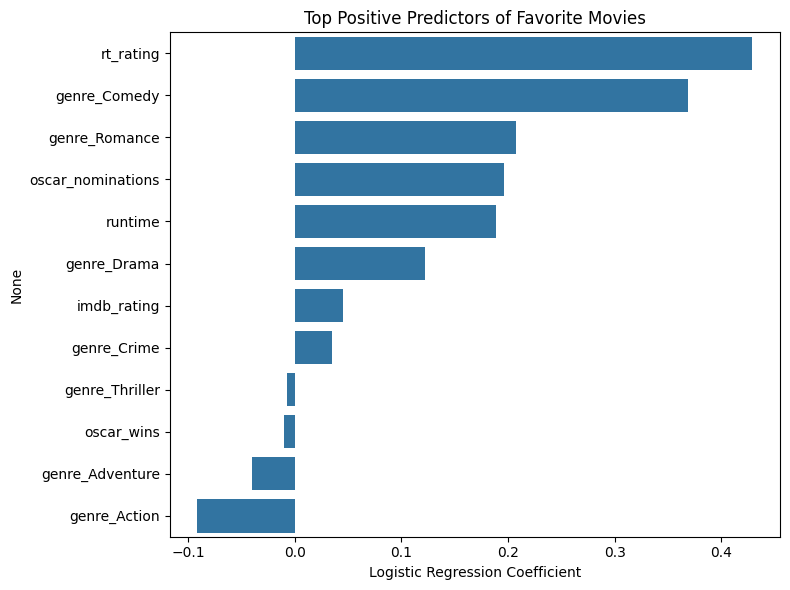

In [46]:
coef_df = pd.Series(
    log_model.coef_[0],
    index=X.columns
).sort_values(ascending=False)

coef_df.head(10)

top_features = coef_df.head(12)

plt.figure(figsize=(8,6))
sns.barplot(
    x=top_features.values,
    y=top_features.index,

)
plt.title("Top Positive Predictors of Favorite Movies")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()

